In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta, date
from humanize import naturalsize
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Loading data

First you will need to run `job_stats_generation.py` in Qiita as the qiita user (or whatever user runs qiita in your system)

In [2]:
# ['JobID', 'ElapsedRaw', 'MaxRSS', 'QiitaID', 'external_id', 'sId',
#  'sName', 'sVersion', 'cId', 'cName', 'samples', 'columns', 'input_size',
#  'MaxRSSRaw'],

date_fmt = '%Y-%m-%dT%H:%M:%S'
m1g = 2**30

df = []
for eid, __df in pd.read_csv(
        'job_stats_071223.tsv.gz', sep='\t', dtype={'extra_info': str}).groupby('external_id'):
    tmp = __df.iloc[1].copy()
    # Calculating WaitTime, basically how long did the job took to start
    # this is useful for some general profiling
    tmp['WaitTime'] = datetime.strptime(
        __df.iloc[0].Start, date_fmt) - datetime.strptime(
        __df.iloc[0].Submit, date_fmt)
    
    df.append(tmp)
df = pd.DataFrame(df)

# This is important as we are transforming the MaxRSS to raw value
# so we need to confirm that there is no other values
print('Make sure that only 0/K/M exist', set(df.MaxRSS.apply(lambda x: x[-1])))

def _helper(x):
    if x[-1] == 'K':
        y = float(x[:-1]) * 1000
    elif x[-1] == 'M':
        y = float(x[:-1]) * 1000000
    else:
        y = float(x)
    return y

# Generating new columns
df['MaxRSSRaw'] = df.MaxRSS.apply(lambda x: _helper(x))
df['ElapsedRawTime'] = df.ElapsedRaw.apply(lambda x: timedelta(seconds=float(x)))

# Thu, Apr 27, 2023 was the first time Jeff and I changed the old allocations
# (from barnacle) to a better allocation so using job 1265533 as the before/after
# so we only use the latests for the newest version
df['updated'] = df.external_id.apply(lambda x: 'after' if x >= 1265533 else 'before') 

Make sure that only 0/K/M exist {'0', 'K', 'M'}


# Main summary

Just showing the first 15, this is helpful to see the huge differences between before and after the first set of changes were made.

In [3]:
summary = df.groupby(['cName', 'sName', 'updated'])[
    ['ElapsedRawTime', 'MaxRSSRaw', 'WaitTime']].agg(['count', 'min', 'max']).copy()
summary[('MaxRSSRaw', 'min')] = summary[('MaxRSSRaw', 'min')].apply(naturalsize)
summary[('MaxRSSRaw', 'max')] = summary[('MaxRSSRaw', 'max')].apply(naturalsize)
summary.drop(columns=[('WaitTime', 'count')], inplace=True)
summary.drop(columns=[('MaxRSSRaw', 'count')], inplace=True)
summary.sort_values(('ElapsedRawTime', 'count'), inplace=True, ascending=False)
print('Total jobs before/after:', summary.shape[0])
display(summary.head(10))

display(summary[summary.index.get_level_values('cName') == 'Sequence Processing Pipeline'])

Total jobs before/after: 137


ElapsedRawTime  \
                                                                           count   
cName              sName                                  updated                  
complete_job       Qiita                                  before           27460   
Validate           BIOM type - BIOM                       before            8281   
complete_job       Qiita                                  after             8114   
release_validators Qiita                                  before            7787   
                                                          after             2849   
Validate           Visualization types - q2_visualization before            2667   
                   BIOM type - BIOM                       after             1967   
                   Diversity types - distance_matrix      before            1519   
                   Diversity types - alpha_vector         before            1435   
                   Diversity types - ordination_results   before            1357   

                                                                                   \
                                                                              min   
cName              sName                                  updated                   
complete_job       Qiita                                  before  0 days 00:00:02   
Validate           BIOM type - BIOM                       before  0 days 00:00:50   
complete_job       Qiita                                  after   0 days 00:00:02   
release_validators Qiita                                  before  0 days 00:00:05   
                                                          after   0 days 00:00:06   
Validate           Visualization types - q2_visualization before  0 days 00:00:36   
                   BIOM type - BIOM                       after   0 days 00:01:01   
                   Diversity types - distance_matrix      before  0 days 00:00:35   
                   Diversity types - alpha_vector         before  0 days 00:01:05   
                   Diversity types - ordination_results   before  0 days 00:00:37   

                                                                                   \
                                                                              max   
cName              sName                                  updated                   
complete_job       Qiita                                  before  0 days 09:15:17   
Validate           BIOM type - BIOM                       before  0 days 03:48:28   
complete_job       Qiita                                  after   0 days 02:27:09   
release_validators Qiita                                  before  7 days 18:06:13   
                                                          after   6 days 09:07:42   
Validate           Visualization types - q2_visualization before  0 days 00:25:54   
                   BIOM type - BIOM                       after   0 days 05:45:07   
                   Diversity types - distance_matrix      before  0 days 00:26:41   
                   Diversity types - alpha_vector         before  3 days 04:36:54   
                   Diversity types - ordination_results   before  0 days 00:21:52   

                                                                  MaxRSSRaw  \
                                                                        min   
cName              sName                                  updated             
complete_job       Qiita                                  before    0 Bytes   
Validate           BIOM type - BIOM                       before   179.8 MB   
complete_job       Qiita                                  after     0 Bytes   
release_validators Qiita                                  before    0 Bytes   
                                                          after     0 Bytes   
Validate           Visualization types - q2_visualization before    38.5 MB   
                   BIOM type - BIOM               

ElapsedRawTime                  \
                                                     count             min   
cName                        sName  updated                                  
Sequence Processing Pipeline qp-klp before             128 0 days 00:03:30   
                                    after               78 0 days 00:02:25   

                                                            MaxRSSRaw  \
                                                        max       min   
cName                        sName  updated                             
Sequence Processing Pipeline qp-klp before  1 days 01:10:34  122.5 MB   
                                    after   0 days 16:11:31  153.3 MB   

                                                     WaitTime                  
                                                 max      min             max  
cName                        sName  updated                                    
Sequence Processing Pipeline qp-klp before    4.6 GB   0 days 0 days 00:00:30  
                                    after    10.1 GB   0 days 0 days 00:00:29

In [4]:
summary = df.groupby(['cName', 'sName'])[
    ['ElapsedRawTime', 'MaxRSSRaw', 'WaitTime']].agg(['count', 'min', 'max']).copy()
summary[('MaxRSSRaw', 'min')] = summary[('MaxRSSRaw', 'min')].apply(naturalsize)
summary[('MaxRSSRaw', 'max')] = summary[('MaxRSSRaw', 'max')].apply(naturalsize)
summary.sort_values(('MaxRSSRaw', 'count'), inplace=True, ascending=False)

pd.set_option('display.max_rows', len(summary))
display(summary)
pd.reset_option('display.max_rows')

ElapsedRawTime  \
                                                                                                      count   
cName                                              sName                                                      
complete_job                                       Qiita                                              35574   
release_validators                                 Qiita                                              10636   
Validate                                           BIOM type - BIOM                                   10248   
                                                   Visualization types - q2_visualization              3664   
                                                   Diversity types - distance_matrix                   1921   
                                                   Diversity types - alpha_vector                      1745   
                                                   Diversity types - ordination_results                1624   
Beta diversity group significance [beta_group_s... qiime2                                              1307   
delete_artifact                                    Qiita                                               1207   
Validate                                           Sequencing Data Type - Demultiplexed                 938   
build_analysis_files                               Qiita                                                931   
Validate                                           Sequencing Data Type - per_sample_FASTQ              772   
Filter samples from table [filter_samples]         qiime2                                               756   
Principal Coordinate Analysis [pcoa]               qiime2                                               676   
Trimming                                           QIIMEq2                                              634   
Pick closed-reference OTUs                         QIIMEq2                                              633   
update_sample_template                             Qiita                                                607   
Deblur 2021.09                                     deblur                                               587   
Beta diversity (phylogenetic) [beta_phylogenetic]  qiime2                                               548   
Alpha diversity [alpha]                            qiime2                                               521   
Visualize taxonomy with an interactive bar plot... qiime2                                               452   
create_sample_template                             Qiita                                                423   
Rarefy table [rarefy]                              qiime2                                               411   
Beta diversity [beta]                              qiime2                                               400   
adonis PERMANOVA test for beta group significan... qiime2                                               374   
Split libraries FASTQ                              QIIMEq2                                              304   
delete_sample_or_column                            Qiita                                                288   
delete_analysis                                    Qiita                                                237   
Alpha diversity (phylogenetic) [alpha_phylogene... qiime2                                               217   
Validate                                           qtp-job-output-folder - job-output-folder            206   
Sequence Processing Pipeline                       qp-klp                                               206   
Core diversity metrics (phylogenetic and non-ph... qiime2                                               196   
Alpha rarefaction curves [alpha_rarefaction]       qiime2                                               193   
download_remote_files                              Qiita                                         

# Deciding what to optimize and what to leave with a default value

This is a tricky step and it boils down to how much do we really need to optimize and focus. On one hand, it would be great if we could always request the exact amount of walltime and memory a job will use; then on the other, there is a defined amount of cores in each node. Note that the decision below can change in the future.

The below cells will have a `# *** RESOURCE ALLOCATION ***` comment to easily find where we will have a new allocation that we would need to apply.

In [5]:
summary = df.groupby(['cName', 'sName'])[
        ['ElapsedRawTime', 'MaxRSSRaw']].agg(['count', 'min', 'max']).copy()

# We are gonna  focus on jobs that request more than 4gb or take more than 4hrs.
summary = summary[(summary[('MaxRSSRaw', 'max')] > 4*m1g) | 
                  (summary[('ElapsedRawTime', 'max')] > timedelta(hours=4))]
# current allocation:
# RESOURCE_PARAMS_COMMAND | -p qiita -N 1 -n 1 --mem 8gb --time 32:00:00

# *** RESOURCE ALLOCATION ***
# UPDATE qiita.processing_job_resource_allocation set allocation = '-p qiita -N 1 -n 1 --mem 4gb --time 4:00:00' 
#    WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and name = 'default';

# Next let's add an allocation to those jobs that are really close between max/min
summary_ignore = summary[(summary[('MaxRSSRaw', 'min')] * 25 > summary[('MaxRSSRaw', 'max')])].copy()
summary_ignore[('MaxRSSRaw', 'min')] = summary_ignore[('MaxRSSRaw', 'min')].apply(naturalsize)
summary_ignore[('MaxRSSRaw', 'max')] = summary_ignore[('MaxRSSRaw', 'max')].apply(naturalsize)
display(summary_ignore)

# Previous allocations
# Apply ANCOM to identify features that differ in abundance. [ancom] |
#     | RESOURCE_PARAMS_COMMAND | -p qiita -N 1 -n 1 --mem 8gb --time 3-10:00:00
# Beta diversity rarefaction [beta_rarefaction] |
#     | RESOURCE_PARAMS_COMMAND | -p qiita -N 1 -n 1 --mem 100gb --time 50:00:00
# Filter features against reference [filter_features] |
#     | RESOURCE_PARAMS_COMMAND | -p qiita -N 1 -n 1 --mem 32gb --time 32:00:00
# bioenv [bioenv] -> no resource allocation

# *** RESOURCE ALLOCATION ***
# UPDATE qiita.processing_job_resource_allocation set allocation = '-p qiita -N 1 -n 1 --mem 7gb --time 40:00:00' 
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Apply ANCOM to identify features that differ in abundance. [ancom]';

# UPDATE qiita.processing_job_resource_allocation set allocation = '-p qiita -N 1 -n 1 --mem 6gb --time 10:00:00' 
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Beta diversity rarefaction [beta_rarefaction]';

# UPDATE qiita.processing_job_resource_allocation set allocation = '-p qiita -N 1 -n 1 --mem 13gb --time 1:00:00' 
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Filter features against reference [filter_features]';

# INSERT INTO qiita.processing_job_resource_allocation (name, job_type, allocation) 
#     VALUES ('bioenv [bioenv]', 'RESOURCE_PARAMS_COMMAND', '-p qiita -N 1 -n 1 --mem 6gb --time 1:00:00');

ElapsedRawTime  \
                                                                                                    count   
cName                                              sName                                                    
Apply ANCOM to identify features that differ in... qiime2                                              60   
Beta diversity rarefaction [beta_rarefaction]      qiime2                                              42   
Filter features against reference [filter_featu... qiime2                                              22   
Validate                                           Sequencing Data Type - per_sample_FASTQ            772   
bioenv [bioenv]                                    qiime2                                               5   

                                                                                                            \
                                                                                                       min   
cName                                              sName                                                     
Apply ANCOM to identify features that differ in... qiime2                                  0 days 00:00:55   
Beta diversity rarefaction [beta_rarefaction]      qiime2                                  0 days 00:02:36   
Filter features against reference [filter_featu... qiime2                                  0 days 00:02:07   
Validate                                           Sequencing Data Type - per_sample_FASTQ 0 days 00:00:34   
bioenv [bioenv]                                    qiime2                                  0 days 00:01:23   

                                                                                                            \
                                                                                                       max   
cName                                              sName                                                     
Apply ANCOM to identify features that differ in... qiime2                                  1 days 07:50:45   
Beta diversity rarefaction [beta_rarefaction]      qiime2                                  0 days 05:27:33   
Filter features against reference [filter_featu... qiime2                                  0 days 00:18:52   
Validate                                           Sequencing Data Type - per_sample_FASTQ 0 days 18:13:21   
bioenv [bioenv]                                    qiime2                                  0 days 00:04:15   

                                                                                           MaxRSSRaw  \
                                                                                               count   
cName                                              sName                                               
Apply ANCOM to identify features that differ in... qiime2                                         60   
Beta diversity rarefaction [beta_rarefaction]      qiime2                                         42   
Filter features against reference [filter_featu... qiime2                                         22   
Validate                                           Sequencing Data Type - per_sample_FASTQ       772   
bioenv [bioenv]                                    qiime2                                          5   

                                                                                                      \
                                                                                                 min   
cName                                              sName                                               
Apply ANCOM to identify features that differ in... qiime2                                   212.0 MB   
Beta diversity rarefaction [beta_rarefaction]      qiime2                                   237.8 MB   
Filter features against reference [filter_featu... qiime2                                     8.8 GB   

## Optimizing commands

Based on the decision above, we will focus on the following commands.

In [6]:
summary = df[df.updated == 'after'].groupby(['cName', 'sName'])[
    ['ElapsedRawTime', 'MaxRSSRaw']].agg(['count', 'min', 'max']).copy()
summary = summary[(summary[('MaxRSSRaw', 'max')] > 4*m1g) | 
                  (summary[('ElapsedRawTime', 'max')] > timedelta(hours=4))]

summary.sort_values(('MaxRSSRaw', 'count'), inplace=True, ascending=False)

summary[('MaxRSSRaw', 'min')] = summary[('MaxRSSRaw', 'min')].apply(naturalsize)
summary[('MaxRSSRaw', 'max')] = summary[('MaxRSSRaw', 'max')].apply(naturalsize)

summary.drop(columns=[('MaxRSSRaw', 'count')], inplace=True)

_df = summary[summary.index.get_level_values('sName') != 'qiime2']
print ("qiita:", _df.shape[0])
display(_df)

_df = summary[summary.index.get_level_values('sName') == 'qiime2']
print ("qiime2:", _df.shape[0])
display(_df)

qiita: 14


ElapsedRawTime  \
                                                                           count   
cName                        sName                                                 
release_validators           Qiita                                          2849   
Validate                     BIOM type - BIOM                               1967   
                             Diversity types - distance_matrix               402   
                             Diversity types - alpha_vector                  310   
                             Sequencing Data Type - Demultiplexed            256   
Pick closed-reference OTUs   QIIMEq2                                         197   
build_analysis_files         Qiita                                           195   
Trimming                     QIIMEq2                                         172   
Deblur 2021.09               deblur                                          161   
update_sample_template       Qiita                                           160   
Split libraries FASTQ        QIIMEq2                                          84   
Sequence Processing Pipeline qp-klp                                           78   
delete_sample_or_column      Qiita                                            50   
submit_to_EBI                Qiita                                            16   

                                                                                   \
                                                                              min   
cName                        sName                                                  
release_validators           Qiita                                0 days 00:00:06   
Validate                     BIOM type - BIOM                     0 days 00:01:01   
                             Diversity types - distance_matrix    0 days 00:00:38   
                             Diversity types - alpha_vector       0 days 00:01:16   
                             Sequencing Data Type - Demultiplexed 0 days 00:00:36   
Pick closed-reference OTUs   QIIMEq2                              0 days 00:09:45   
build_analysis_files         Qiita                                0 days 00:01:23   
Trimming                     QIIMEq2                              0 days 00:00:39   
Deblur 2021.09               deblur                               0 days 00:02:44   
update_sample_template       Qiita                                0 days 00:00:04   
Split libraries FASTQ        QIIMEq2                              0 days 00:00:53   
Sequence Processing Pipeline qp-klp                               0 days 00:02:25   
delete_sample_or_column      Qiita                                0 days 00:00:05   
submit_to_EBI                Qiita                                0 days 00:05:06   

                                                                                   \
                                                                              max   
cName                        sName                                                  
release_validators           Qiita                                6 days 09:07:42   
Validate                     BIOM type - BIOM                     0 days 05:45:07   
                             Diversity types - distance_matrix    0 days 00:08:06   
                             Diversity types - alpha_vector       0 days 05:00:08   
                             Sequencing Data Type - Demultiplexed 0 days 06:07:11   
Pick closed-reference OTUs   QIIMEq2                              4 days 04:30:41   
build_analysis_files         Qiita                                1 days 06:30:21   
Trimming                     QIIMEq2                              0 days 09:09:47   
Deblur 2021.09               deblur                               1 days 00:27:50   
update_sample_template       Qiita                                0 days 00:33:08   
Split libraries FASTQ        QIIMEq2                              0 days 13:50:09   
S

qiime2: 9


ElapsedRawTime  \
                                                                   count   
cName                                              sName                   
Filter samples from table [filter_samples]         qiime2            230   
Beta diversity (phylogenetic) [beta_phylogenetic]  qiime2            195   
Rarefy table [rarefy]                              qiime2             88   
Alpha diversity (phylogenetic) [alpha_phylogene... qiime2             52   
Pre-fitted sklearn-based taxonomy classifier [c... qiime2             24   
Visualize and Interact with Principal Coordinat... qiime2             20   
Apply ANCOM to identify features that differ in... qiime2             20   
Filter features against reference [filter_featu... qiime2             19   
Alpha rarefaction curves [alpha_rarefaction]       qiime2             14   

                                                                           \
                                                                      min   
cName                                              sName                    
Filter samples from table [filter_samples]         qiime2 0 days 00:00:57   
Beta diversity (phylogenetic) [beta_phylogenetic]  qiime2 0 days 00:01:04   
Rarefy table [rarefy]                              qiime2 0 days 00:00:55   
Alpha diversity (phylogenetic) [alpha_phylogene... qiime2 0 days 00:01:08   
Pre-fitted sklearn-based taxonomy classifier [c... qiime2 0 days 00:01:42   
Visualize and Interact with Principal Coordinat... qiime2 0 days 00:01:20   
Apply ANCOM to identify features that differ in... qiime2 0 days 00:01:15   
Filter features against reference [filter_featu... qiime2 0 days 00:02:07   
Alpha rarefaction curves [alpha_rarefaction]       qiime2 0 days 00:17:18   

                                                                           \
                                                                      max   
cName                                              sName                    
Filter samples from table [filter_samples]         qiime2 0 days 00:10:13   
Beta diversity (phylogenetic) [beta_phylogenetic]  qiime2 0 days 00:13:55   
Rarefy table [rarefy]                              qiime2 0 days 00:35:37   
Alpha diversity (phylogenetic) [alpha_phylogene... qiime2 0 days 00:05:28   
Pre-fitted sklearn-based taxonomy classifier [c... qiime2 0 days 08:04:39   
Visualize and Interact with Principal Coordinat... qiime2 0 days 00:10:50   
Apply ANCOM to identify features that differ in... qiime2 1 days 07:50:45   
Filter features against reference [filter_featu... qiime2 0 days 00:18:52   
Alpha rarefaction curves [alpha_rarefaction]       qiime2 1 days 13:21:15   

                                                          MaxRSSRaw           
                                                                min      max  
cName                                              sName                      
Filter samples from table [filter_samples]         qiime2  244.5 MB  24.8 GB  
Beta diversity (phylogenetic) [beta_phylogenetic]  qiime2  241.2 MB  13.5 GB  
Rarefy table [rarefy]                              qiime2   79.2 MB  12.3 GB  
Alpha diversity (phylogenetic) [alpha_phylogene... qiime2  231.0 MB  13.3 GB  
Pre-fitted sklearn-based taxonomy classifier [c... qiime2  959.0 MB  43.4 GB  
Visualize and Interact with Principal Coordinat... qiime2  243.3 MB  25.1 GB  
Apply ANCOM to identify features that differ in... qiime2  249.9 MB   5.2 GB  
Filter features against reference [filter_featu... qiime2    8.8 GB  11.1 GB  
Alpha rarefaction curves [alpha_rarefaction]       qiime2  206.7 MB   2.8 GB

## Optimizing Qiita processing jobs.

As a remider, we can use:
- 'samples'
- 'columns'
- 'input_size'
- 'extra_info': this is when the current method doesn't provide the required info or we need to update it; this info comes from `job_stats_generation.py`

#### Complete jobs 

In [7]:
# COMPLETE_JOBS_RESOURCE_PARAM
cmd = 'complete_job'
summary = df[df.cName == cmd].groupby(
    ['cName', 'sName', 'extra_info'], dropna=False)[
    ['ElapsedRawTime', 'MaxRSSRaw', 'WaitTime']].agg(['count', 'min', 'max']).copy()
summary[('MaxRSSRaw', 'min')] = summary[('MaxRSSRaw', 'min')].apply(naturalsize)
summary[('MaxRSSRaw', 'max')] = summary[('MaxRSSRaw', 'max')].apply(naturalsize)
summary.drop(columns=[('MaxRSSRaw', 'count')], inplace=True)
summary.drop(columns=[('WaitTime', 'count')], inplace=True)
summary.sort_values(('ElapsedRawTime', 'max'), inplace=True, ascending=False)

display(summary.head(10))

# The current allocation for all complete jobs is 
# COMPLETE_JOBS_RESOURCE_PARAM | -p qiita -N 1 -n 1 --mem 1gb --time 11:00:00 --qos=qiita_prio

# Let's decrement the default and add specific allocations for the top 2

# *** RESOURCE ALLOCATION ***
# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 --mem 500mb --time 00:20:00 --qos=qiita_prio' 
#     WHERE job_type = 'COMPLETE_JOBS_RESOURCE_PARAM' and 
#     name = 'default';

# INSERT INTO qiita.processing_job_resource_allocation (name, job_type, allocation) 
#     VALUES ('per_sample_FASTQ', 'COMPLETE_JOBS_RESOURCE_PARAM', 
#             '-p qiita -N 1 -n 1 --mem 200mb --time 10:00:00 --qos=qiita_prio');
# INSERT INTO qiita.processing_job_resource_allocation (name, job_type, allocation) 
#     VALUES ('FASTQ', 'COMPLETE_JOBS_RESOURCE_PARAM', 
#             '-p qiita -N 1 -n 1 --mem 200mb --time 1:00:00 --qos=qiita_prio');
# INSERT INTO qiita.processing_job_resource_allocation (name, job_type, allocation) 
#     VALUES ('job-output-folder', 'COMPLETE_JOBS_RESOURCE_PARAM', 
#             '-p qiita -N 1 -n 1 --mem 200mb --time 1:00:00 --qos=qiita_prio');

ElapsedRawTime                  \
                                               count             min   
cName        sName extra_info                                          
complete_job Qiita per_sample_FASTQ             1079 0 days 00:00:03   
                   FASTQ                         163 0 days 00:00:04   
                   job-output-folder             414 0 days 00:00:03   
                   NaN                          3240 0 days 00:00:03   
                   BIOM                        13880 0 days 00:00:02   
                   Demultiplexed                1877 0 days 00:00:03   
                   q2_visualization             6432 0 days 00:00:02   
                   ordination_results           2363 0 days 00:00:03   
                   distance_matrix              2945 0 days 00:00:03   
                   alpha_vector                 2549 0 days 00:00:03   

                                                      MaxRSSRaw            \
                                                  max       min       max   
cName        sName extra_info                                               
complete_job Qiita per_sample_FASTQ   0 days 09:15:17   0 Bytes  126.9 MB   
                   FASTQ              0 days 00:57:30   0 Bytes  122.0 MB   
                   job-output-folder  0 days 00:47:35   0 Bytes  120.3 MB   
                   NaN                0 days 00:15:03   0 Bytes  120.5 MB   
                   BIOM               0 days 00:12:51   0 Bytes  232.8 MB   
                   Demultiplexed      0 days 00:11:52   0 Bytes  121.5 MB   
                   q2_visualization   0 days 00:10:49   0 Bytes  120.7 MB   
                   ordination_results 0 days 00:06:57   0 Bytes  120.6 MB   
                   distance_matrix    0 days 00:05:32   0 Bytes  120.7 MB   
                   alpha_vector       0 days 00:05:10   0 Bytes  120.7 MB   

                                      WaitTime                  
                                           min             max  
cName        sName extra_info                                   
complete_job Qiita per_sample_FASTQ     0 days 0 days 00:00:47  
                   FASTQ                0 days 0 days 00:00:28  
                   job-output-folder    0 days 0 days 00:00:28  
                   NaN                  0 days 0 days 06:11:55  
                   BIOM                 0 days 0 days 03:32:11  
                   Demultiplexed        0 days 0 days 00:25:35  
                   q2_visualization     0 days 0 days 00:00:37  
                   ordination_results   0 days 0 days 00:00:42  
                   distance_matrix      0 days 0 days 00:00:44  
                   alpha_vector         0 days 0 days 00:00:30

#### Release validator jobs

In [8]:
# RELEASE_VALIDATORS_RESOURCE_PARAM
cmd = 'release_validators'
_df = df[(df.cName == cmd) & (df.updated == 'after')].copy()
summary = _df.groupby(
    ['cName', 'sName', 'extra_info'], dropna=False)[
    ['ElapsedRawTime', 'MaxRSSRaw']].agg(['count', 'min', 'max']).copy()
summary[('MaxRSSRaw', 'min')] = summary[('MaxRSSRaw', 'min')].apply(naturalsize)
summary[('MaxRSSRaw', 'max')] = summary[('MaxRSSRaw', 'max')].apply(naturalsize)
summary.sort_values(('ElapsedRawTime', 'max'), inplace=True, ascending=False)
summary.drop(columns=[('MaxRSSRaw', 'count')], inplace=True)

print(summary.shape[0])
display(summary.head(11))

# Note: after investigation (not shown), there is no easy 
#       formula so going to make the requests as close as possible to the max

# the max memory is ~170mb

# Current allocations:

#  Adapter and host filtering                                                             |
#      -p qiita -N 1 -n 1 --mem 1gb --time 18:37:28
#  Alpha diversity (phylogenetic) [alpha_phylogenetic]                                    |
#      -p qiita -N 1 -n 1 --mem 1gb --time 2-21:43:10
#  Alpha diversity [alpha]                                                                |
#      -p qiita -N 1 -n 1 --mem 1gb --time 4-21:21:34
#  Beta diversity (phylogenetic) [beta_phylogenetic]                                      |
#      -p qiita -N 1 -n 1 --mem 1gb --time 1-0:17:33
#  Beta diversity [beta]                                                                  |
#      -p qiita -N 1 -n 1 --mem 1gb --time 1-0:14:54
#  Beta diversity correlation [beta_correlation]                                          |
#      -p qiita -N 1 -n 1 --mem 1gb --time 2-7:04:33
#  Beta diversity group significance [beta_group_significance]                            |
#      -p qiita -N 1 -n 1 --mem 1gb --time 1-23:28:00
#  Core diversity metrics (non-phylogenetic) [core_metrics]                               |
#      -p qiita -N 1 -n 1 --mem 1gb --time 6-13:33:12
#  Core diversity metrics (phylogenetic and non-phylogenetic) [core_metrics_phylogenetic] |
#      -p qiita -N 1 -n 1 --mem 1gb --time 11-15:09:19
#  Deblur 2021.09                                                                         |
#      -p qiita -N 1 -n 1 --mem 1gb --time 1-2:15:37
#  Filter samples from a distance matrix. [filter_distance_matrix]                        |
#      -p qiita -N 1 -n 1 --mem 1gb --time 22:05:27
#  Filter samples from table [filter_samples]                                             |
#      -p qiita -N 1 -n 1 --mem 1gb --time 1-0:44:07
#  Pick closed-reference OTUs                                                             |
#      -p qiita -N 1 -n 1 --mem 1gb --time 11:01:04
#  Pre-fitted sklearn-based taxonomy classifier [classify_sklearn]                        |
#      -p qiita -N 1 -n 1 --mem 1gb --time 4-9:21:43
#  Rarefy table [rarefy]                                                                  |
#      -p qiita -N 1 -n 1 --mem 1gb --time 8:23:54
#  Sortmerna v2.1b                                                                        |
#      -p qiita -N 1 -n 1 --mem 1gb --time 6:58:15
#  Split libraries FASTQ                                                                  |
#      -p qiita -N 1 -n 1 --mem 1gb --time 6:20:01
#  Trimming                                                                               |
#      -p qiita -N 1 -n 1 --mem 1gb --time 1-2:07:00
#  Woltka v0.1.1                                                                          |
#      -p qiita -N 1 -n 1 --mem 1gb --time 5:11:34
#  Woltka v0.1.4                                                                          |
#      -p qiita -N 1 -n 1 --mem 1gb --time 2-18:20:52
#  default                                                                                |
#      -p qiita -N 1 -n 1 --mem 1g --time 2:00:00

# *** RESOURCE ALLOCATION ***
# 1. let's remove the old allocations
#   DELETE FROM qiita.processing_job_resource_allocation 
#       WHERE job_type = 'RELEASE_VALIDATORS_RESOURCE_PARAM' and name != 'default';
# 2. update the default 
# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 --mem 200mb --time 4:00:00' 
#     WHERE job_type = 'RELEASE_VALIDATORS_RESOURCE_PARAM' and 
#     name = 'default';

# INSERT INTO qiita.processing_job_resource_allocation (name, job_type, allocation) 
#     VALUES ('Core diversity metrics (non-phylogenetic) [core_metrics]', 'RELEASE_VALIDATORS_RESOURCE_PARAM', 
#             '-p qiita -N 1 -n 1 --mem 150mb --time 6-15:00:00');
# INSERT INTO qiita.processing_job_resource_allocation (name, job_type, allocation) 
#     VALUES ('Core diversity metrics (phylogenetic and non-phylogenetic) [core_metrics_phylogenetic]', 
#             'RELEASE_VALIDATORS_RESOURCE_PARAM', '-p qiita -N 1 -n 1 --mem 150mb --time 2-9:00:00');
# INSERT INTO qiita.processing_job_resource_allocation (name, job_type, allocation) 
#     VALUES ('Beta diversity (phylogenetic) [beta_phylogenetic]', 'RELEASE_VALIDATORS_RESOURCE_PARAM', 
#             '-p qiita -N 1 -n 1 --mem 150mb --time 18:00:00');
# INSERT INTO qiita.processing_job_resource_allocation (name, job_type, allocation) 
#     VALUES ('Alpha diversity (phylogenetic) [alpha_phylogenetic]', 'RELEASE_VALIDATORS_RESOURCE_PARAM', 
#             '-p qiita -N 1 -n 1 --mem 150mb --time 19:00:00');
# INSERT INTO qiita.processing_job_resource_allocation (name, job_type, allocation) 
#     VALUES ('Beta diversity [beta]', 'RELEASE_VALIDATORS_RESOURCE_PARAM', 
#             '-p qiita -N 1 -n 1 --mem 150mb --time 18:00:00');
# INSERT INTO qiita.processing_job_resource_allocation (name, job_type, allocation) 
#     VALUES ('Alpha diversity [alpha]', 'RELEASE_VALIDATORS_RESOURCE_PARAM', 
#             '-p qiita -N 1 -n 1 --mem 150mb --time 16:00:00');
# INSERT INTO qiita.processing_job_resource_allocation (name, job_type, allocation) 
#     VALUES ('Deblur 2021.09', 'RELEASE_VALIDATORS_RESOURCE_PARAM', 
#             '-p qiita -N 1 -n 1 --mem 150mb --time 11:00:00');
# INSERT INTO qiita.processing_job_resource_allocation (name, job_type, allocation) 
#     VALUES ('Adapter and host filtering', 'RELEASE_VALIDATORS_RESOURCE_PARAM', 
#             '-p qiita -N 1 -n 1 --mem 200mb --time 6:30:00');
# INSERT INTO qiita.processing_job_resource_allocation (name, job_type, allocation) 
#     VALUES ('Trimming', 'RELEASE_VALIDATORS_RESOURCE_PARAM', 
#             '-p qiita -N 1 -n 1 --mem 150mb --time 5:00:00');

40


ElapsedRawTime  \
                                                                                     count   
cName              sName extra_info                                                          
release_validators Qiita Core diversity metrics (non-phylogenetic) [core...             24   
                         Core diversity metrics (phylogenetic and non-ph...             19   
                         Beta diversity (phylogenetic) [beta_phylogenetic]             195   
                         Alpha diversity (phylogenetic) [alpha_phylogene...             52   
                         Beta diversity [beta]                                          81   
                         Alpha diversity [alpha]                                       117   
                         Deblur 2021.09                                                166   
                         Woltka v0.1.4                                                 107   
                         Adapter and host filtering                                     69   
                         Trimming                                                      172   
                         Rarefy table [rarefy]                                          89   

                                                                                             \
                                                                                        min   
cName              sName extra_info                                                           
release_validators Qiita Core diversity metrics (non-phylogenetic) [core... 0 days 00:03:58   
                         Core diversity metrics (phylogenetic and non-ph... 0 days 00:05:53   
                         Beta diversity (phylogenetic) [beta_phylogenetic]  0 days 00:00:06   
                         Alpha diversity (phylogenetic) [alpha_phylogene... 0 days 00:01:39   
                         Beta diversity [beta]                              0 days 00:00:46   
                         Alpha diversity [alpha]                            0 days 00:01:26   
                         Deblur 2021.09                                     0 days 00:01:16   
                         Woltka v0.1.4                                      0 days 00:02:34   
                         Adapter and host filtering                         0 days 00:00:45   
                         Trimming                                           0 days 00:00:46   
                         Rarefy table [rarefy]                              0 days 00:01:18   

                                                                                             \
                                                                                        max   
cName              sName extra_info                                                           
release_validators Qiita Core diversity metrics (non-phylogenetic) [core... 6 days 09:07:42   
                         Core diversity metrics (phylogenetic and non-ph... 2 days 07:53:10   
                         Beta diversity (phylogenetic) [beta_phylogenetic]  0 days 17:26:18   
                         Alpha diversity (phylogenetic) [alpha_phylogene... 0 days 17:17:40   
                         Beta diversity [beta]                              0 days 16:53:16   
                         Alpha diversity [alpha]                            0 days 15:22:15   
                         Deblur 2021.09                                     0 days 09:08:02   
                         Woltka v0.1.4                                      0 days 06:23:36   
                         Adapter and host filtering                         0 days 05:38:41   
                         Trimming                                           0 days 04:07:48   
                         Rarefy table [rarefy]                              0 days 03:28:14   

                                                                            MaxRSSRaw  \
        

#### Validate jobs 

These are based on the artifact_type they are validating, which is part of the job submission and is being
added as part of the software name here

In [9]:
# RELEASE_VALIDATORS_RESOURCE_PARAM
cmd = 'Validate'
# & (df.updated == 'after')
_df = df[(df.cName == cmd)].copy()
summary = _df.groupby(
    ['cName', 'sName'], dropna=False)[
    ['ElapsedRawTime', 'MaxRSSRaw']].agg(['count', 'min', 'max']).copy()

summary = summary[(summary[('MaxRSSRaw', 'max')] > 1*m1g) | 
                  (summary[('ElapsedRawTime', 'max')] > timedelta(hours=1))]

summary[('MaxRSSRaw', 'min')] = summary[('MaxRSSRaw', 'min')].apply(naturalsize)
summary[('MaxRSSRaw', 'max')] = summary[('MaxRSSRaw', 'max')].apply(naturalsize)
summary.sort_values([('ElapsedRawTime', 'max'), ('MaxRSSRaw', 'max')], inplace=True, ascending=False)
summary.drop(columns=[('MaxRSSRaw', 'count')], inplace=True)

display(summary)

ElapsedRawTime  \
                                                          count   
cName    sName                                                    
Validate Diversity types - alpha_vector                    1745   
         Sequencing Data Type - per_sample_FASTQ            772   
         Sequencing Data Type - Demultiplexed               938   
         BIOM type - BIOM                                 10248   
         Diversity types - distance_matrix                 1921   
         Diversity types - ordination_results              1624   
         Diversity types - FeatureData                      147   

                                                                  \
                                                             min   
cName    sName                                                     
Validate Diversity types - alpha_vector          0 days 00:01:05   
         Sequencing Data Type - per_sample_FASTQ 0 days 00:00:34   
         Sequencing Data Type - Demultiplexed    0 days 00:00:35   
         BIOM type - BIOM                        0 days 00:00:50   
         Diversity types - distance_matrix       0 days 00:00:35   
         Diversity types - ordination_results    0 days 00:00:37   
         Diversity types - FeatureData           0 days 00:01:03   

                                                                 MaxRSSRaw  \
                                                             max       min   
cName    sName                                                               
Validate Diversity types - alpha_vector          3 days 04:36:54  186.8 MB   
         Sequencing Data Type - per_sample_FASTQ 0 days 18:13:21   62.5 MB   
         Sequencing Data Type - Demultiplexed    0 days 06:07:11   83.3 MB   
         BIOM type - BIOM                        0 days 05:45:07  125.8 MB   
         Diversity types - distance_matrix       0 days 00:26:41    1.6 MB   
         Diversity types - ordination_results    0 days 00:21:52   74.8 MB   
         Diversity types - FeatureData           0 days 00:18:35  200.9 MB   

                                                            
                                                       max  
cName    sName                                              
Validate Diversity types - alpha_vector           101.5 GB  
         Sequencing Data Type - per_sample_FASTQ   88.7 MB  
         Sequencing Data Type - Demultiplexed       7.3 GB  
         BIOM type - BIOM                         329.2 GB  
         Diversity types - distance_matrix        105.3 GB  
         Diversity types - ordination_results      10.2 GB  
         Diversity types - FeatureData              3.0 GB

Diversity types - distance_matrix    3
BIOM type - BIOM                     3
Name: sName, dtype: int64

Diversity types - alpha_vector    35
Name: sName, dtype: int64

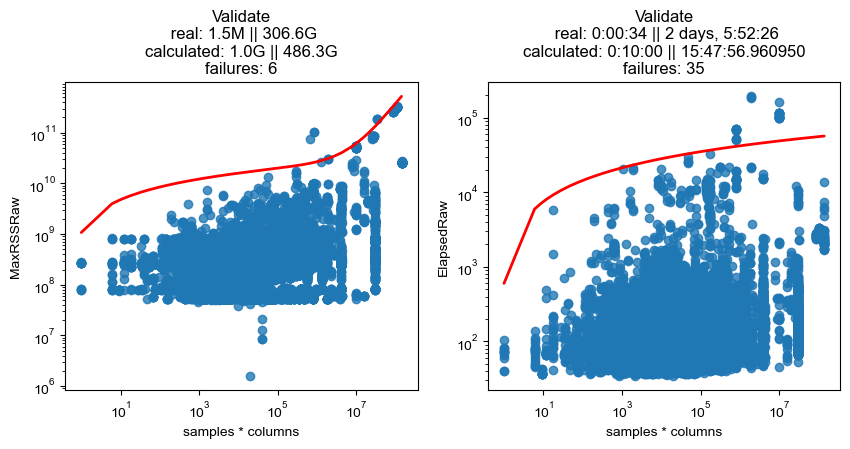

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Validate'
_df = df[(df.cName == cname)
#           & (df.sName.isin(summary.index.get_level_values('sName')))
#           & (df.updated == 'after')
         ].copy()
# fine to dropna as that means that the study or the analysis 
# don't exist anymore AKA not useful
_df.dropna(subset=['samples', 'columns'], inplace=True)

col_name = 'samples * columns'
_df[col_name] = _df.samples * _df['columns']

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = m1g + (np.log(x_plot)*m1g*1.5) + (x_plot*3500)
_df['cMaxRSSRaw'] = m1g + (np.log(_df[col_name])*m1g*1.5) + (_df[col_name]*3500)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures_df = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures_df.shape[0]
display(failures_df.sName.value_counts())

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')

# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 600 + (np.log(x_plot)*3000)
_df['cElapsedRaw'] = 600 + (np.log(_df[col_name])*3000)
axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures_df = _df[_df.ElapsedRaw > _df.cElapsedRaw]
failures = failures_df.shape[0]
display(failures_df.sName.value_counts())

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')



col_name = 'samples * columns'
_df[col_name] = _df.samples * _df['columns']


# *** RESOURCE ALLOCATION ***
# 1. let's remove the old allocations
#   DELETE FROM qiita.processing_job_resource_allocation 
#       WHERE job_type = 'VALIDATOR' and name != 'default';
# 2. update the default 
# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (2**30)+(nlog({samples}*{columns})*(2**30)*1.5)+({samples}*{columns}*3500) '
#            || '--time 600+(nlog({samples}*{columns})*3000)' 
#     WHERE job_type = 'VALIDATOR' and 
#     name = 'default';

### build_analysis_files

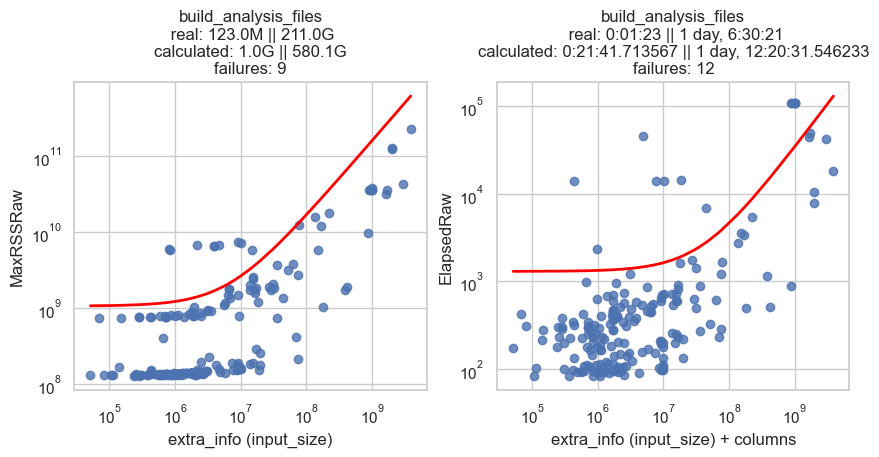

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'build_analysis_files'
_df = df[
    (df.cName == cname)
    & (df.updated == 'after')
].copy()

# convert extra_info, which is the same as input_size but counting only biom
_df['extra_info'] = _df['extra_info'].astype('int')
_df.dropna(subset=['extra_info', 'columns'], inplace=True)

col_name = 'extra_info (input_size)'
_df[col_name] = _df['extra_info']

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = m1g + (x_plot*160)
_df['cMaxRSSRaw'] = m1g + (_df[col_name]*160)
failures_df = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures_df.shape[0]

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')

col_name = 'extra_info (input_size) + columns'
_df[col_name] = _df['extra_info'] + _df['columns']

# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 1300 + (x_plot/30000)
_df['cElapsedRaw'] = 1300 + (_df[col_name]/30000)
axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures_df = _df[_df.ElapsedRaw > _df.cElapsedRaw]
failures = failures_df.shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# the jobs outside due to
#  - memory are due to odd combinations of selections
#  - walltime are because they include waiting for validators

# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (2**30)+({input_size}*160)'
#            || '--time 1300+(({input_size}+{columns})/30000)' 
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'build_analysis_files';

### Pick closed-reference OTUs

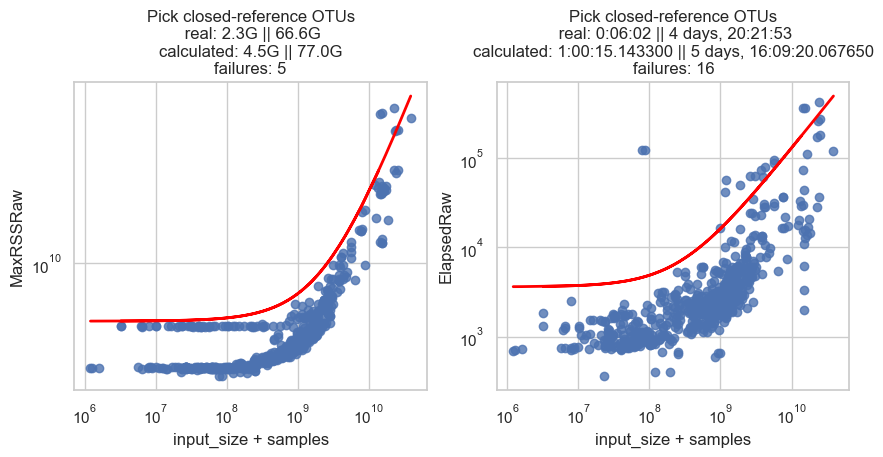

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Pick closed-reference OTUs'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()
col_name = 'input_size + samples'
_df[col_name] = _df.input_size + _df.samples

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (4.5*m1g)+(x_plot*2)
_df['cMaxRSSRaw'] = (4.5*m1g)+(_df[col_name]*2)

failures_df = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures_df.shape[0]

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')


# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 3600+(x_plot/80000)
_df['cElapsedRaw'] = 3600+(_df[col_name]/80000)
axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

failures_df = _df[_df.ElapsedRaw > _df.cElapsedRaw]
failures = failures_df.shape[0]

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# The outliers are 16S NovaSeq

# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (4.5(2**30))+(({input_size}+{samples})*2)'
#            || '--time 3600+(({input_size}+{samples})/80000)' 
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Pick closed-reference OTUs';

### Trimming

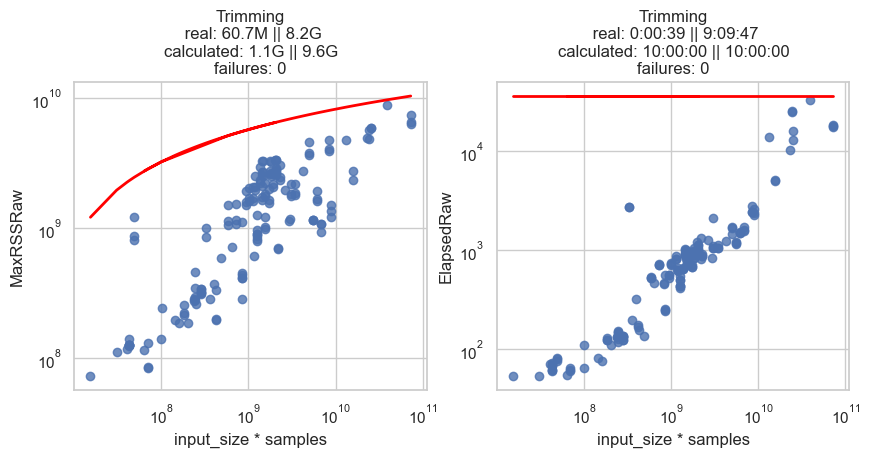

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Trimming'
_df = df[(df.cName == cname)
          & (df.updated == 'after')
         ].copy()
col_name = 'input_size * samples'
_df[col_name] = _df.input_size # * _df.samples

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = np.log(x_plot/5000000)*m1g
_df['cMaxRSSRaw'] = np.log(_df[col_name]/5000000)*m1g

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')


# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = [36000]*len(x_plot)
_df['cElapsedRaw'] = [36000]*len(_df[col_name])
axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem nlog(({input_size}*samples)/5000000)*(2**30)'
#            || '--time 36000'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Trimming';

### update_sample_template

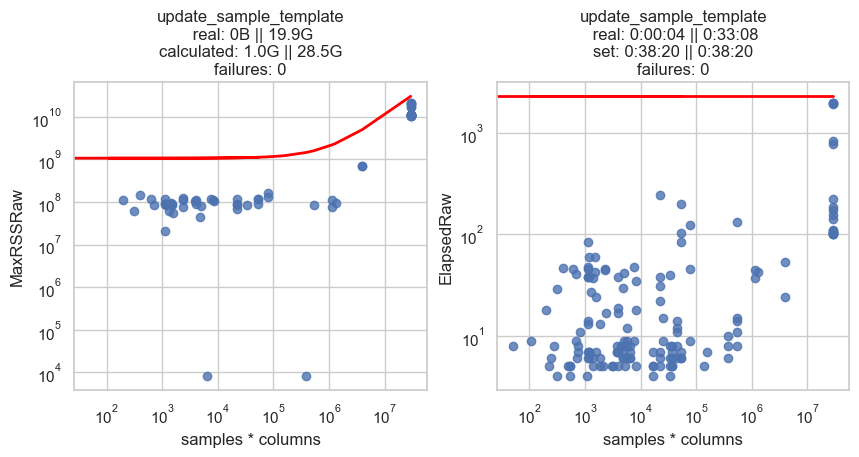

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'update_sample_template'
_df = df[(df.cName == cname)
          & (df.updated == 'after')
         ].copy()
col_name = 'samples * columns'
_df[col_name] = _df.samples * _df['columns']

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (m1g)+(x_plot*1000)
_df['cMaxRSSRaw'] = (m1g)+(_df[col_name]*1000)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')


# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = [2300]*len(x_plot)
_df['cElapsedRaw'] = [2300]*len(_df[col_name])
axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'set: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (2**30)+({samples}*{columns}*1000)'
#            || '--time 2300'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'update_sample_template';

### Deblur 2021.09

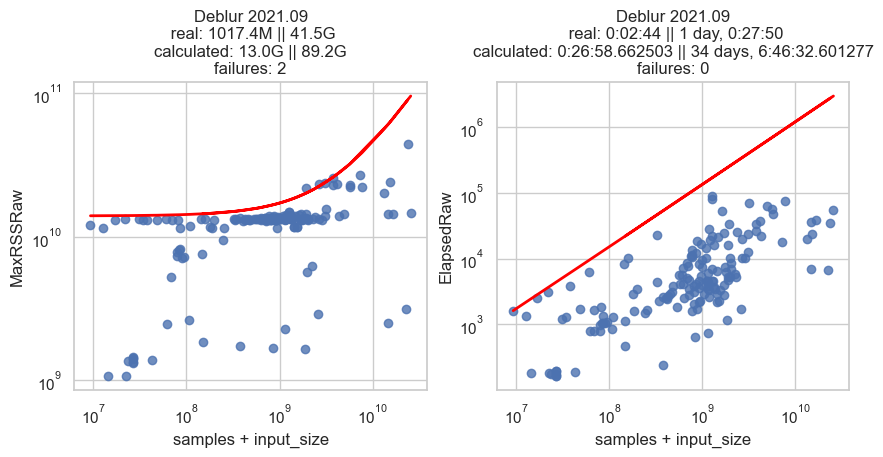

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Deblur 2021.09'
_df = df[(df.cName == cname)
          & (df.updated == 'after')
         ].copy()
col_name = 'samples + input_size'
_df[col_name] = _df.samples + _df.input_size

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (13*m1g)+(x_plot*3.2)
_df['cMaxRSSRaw'] = (13*m1g)+(_df[col_name]*3.2)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')

# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = x_plot/np.log(x_plot)/360
_df['cElapsedRaw'] = _df[col_name]/np.log(_df[col_name])/360

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (13*(2**30))+(({samples}+{input_size})*3.2)'
#            || '--time (({samples}+{input_size})/np.log({samples}+{input_size})/360) '
#            || 'if (({samples}+{input_size})/np.log({samples}+{input_size})/360) < 90000 else 90000'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Deblur 2021.09';

### Split libraries FASTQ

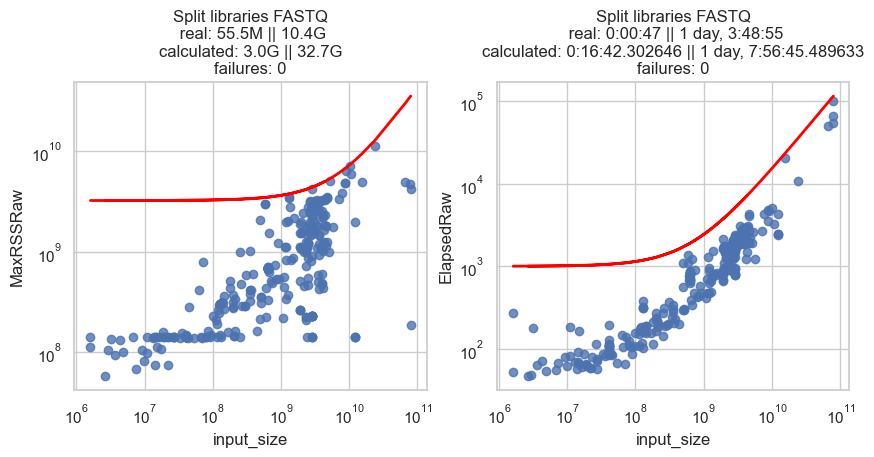

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Split libraries FASTQ'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()

col_name = 'input_size'

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 3*m1g + (x_plot*.4)
_df['cMaxRSSRaw'] = 3*m1g +(_df[col_name]*.4)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')


# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 1000+x_plot/700000
_df['cElapsedRaw'] = 1000+_df[col_name]/700000
# 
axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (3*(2**30))+({input_size}*0.4)'
#            || '--time 1000+({input_size}/700000)'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Split libraries FASTQ';

### delete_sample_or_column

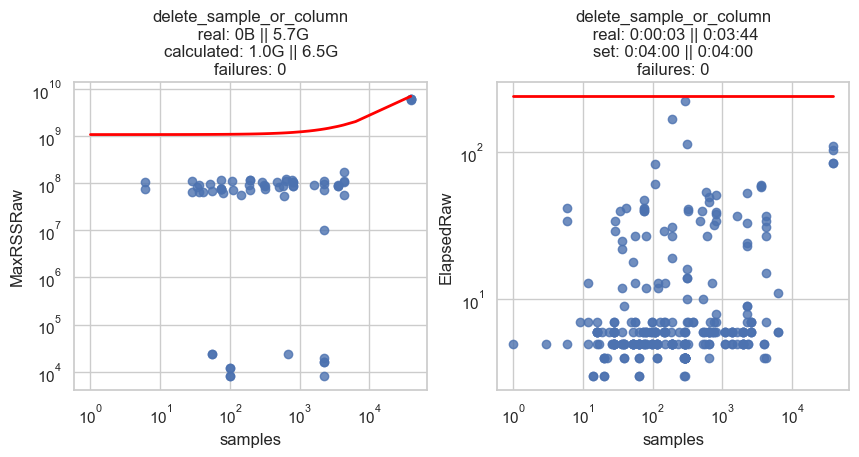

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'delete_sample_or_column'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()

col_name = 'samples'

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = m1g+(x_plot*150000)
_df['cMaxRSSRaw'] = m1g+(_df[col_name]*150000)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')

# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = [240]*len(x_plot)
_df['cElapsedRaw'] = [240]*len(_df[col_name])

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw >= _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'set: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (2**30)+({samples}*150000)'
#            || '--time 240'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Split libraries FASTQ';

### Sequence Processing Pipeline

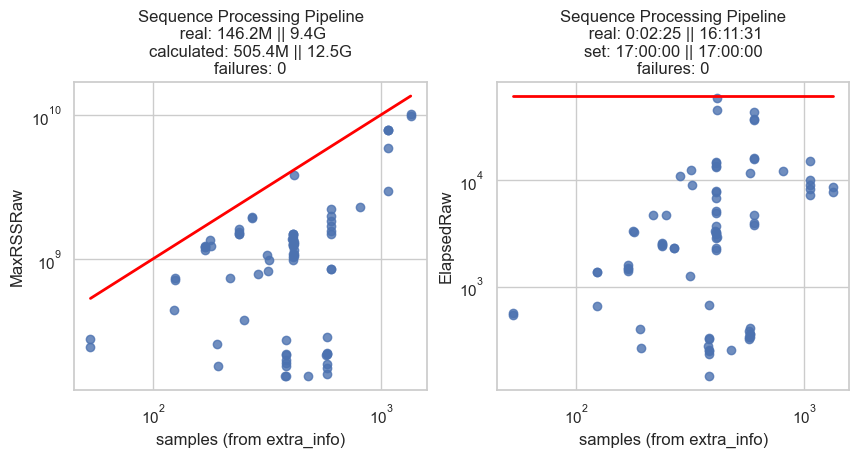

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Sequence Processing Pipeline'
_df = df[(df.cName == cname)
          & (df.updated == 'after')
         ].copy()

col_name = 'samples (from extra_info)'
_df[col_name] = _df.extra_info.apply(lambda x: eval(x)[0])

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (x_plot*10000000)
_df['cMaxRSSRaw'] = _df[col_name]*10000000

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')

# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = [61200]*len(x_plot)
_df['cElapsedRaw'] = [61200]*len(_df[col_name])

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'set: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')


# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem {samples}*10000000'
#            || '--time 61200'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Sequence Processing Pipeline';

### submit_to_EBI

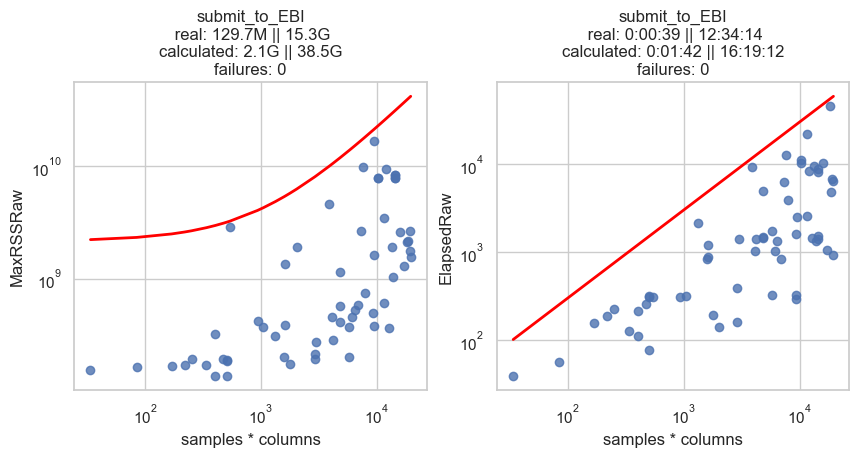

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'submit_to_EBI'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()

col_name = 'samples * columns'
_df[col_name] = _df['samples'] * _df['columns']

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 2*m1g+x_plot*2000000
_df['cMaxRSSRaw'] = 2*m1g+_df[col_name]*2000000

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')
# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = x_plot*3
_df['cElapsedRaw'] = _df[col_name]*3

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem 2*(2**30)*({samples}*{columns}*2000000)'
#            || '--time {samples}*{columns}*3'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'submit_to_EBI';

## Qiime2 commands!

### Filter samples from table [filter_samples]

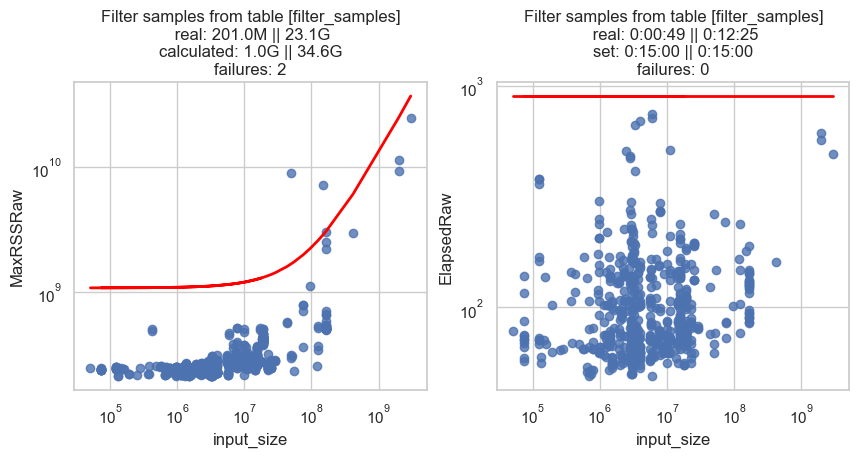

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Filter samples from table [filter_samples]'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()

col_name = 'input_size'

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (m1g)+(x_plot*12)
_df['cMaxRSSRaw'] = (m1g)+(_df[col_name]*12)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')
# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = [900]*len(x_plot)
_df['cElapsedRaw'] = [900]*len(_df[col_name])

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'set: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (2**30)+({input_size}*12)'
#            || '--time 900'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Filter samples from table [filter_samples]';

### Beta diversity (phylogenetic) [beta_phylogenetic]

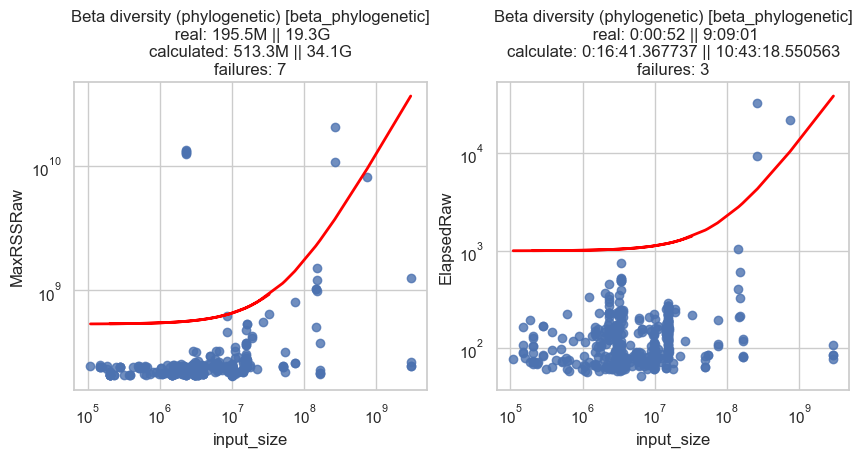

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Beta diversity (phylogenetic) [beta_phylogenetic]'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()

col_name = 'input_size'

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (2**29)+(x_plot*12)
_df['cMaxRSSRaw'] = (2**29)+(_df[col_name]*12)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')
# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 1000+x_plot/80000
_df['cElapsedRaw'] = 1000+_df[col_name]/80000

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculate: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (2**29)+({input_size}*12)'
#            || '--time 1000+x_plot/80000'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Beta diversity (phylogenetic) [beta_phylogenetic]';

### Rarefy table [rarefy]

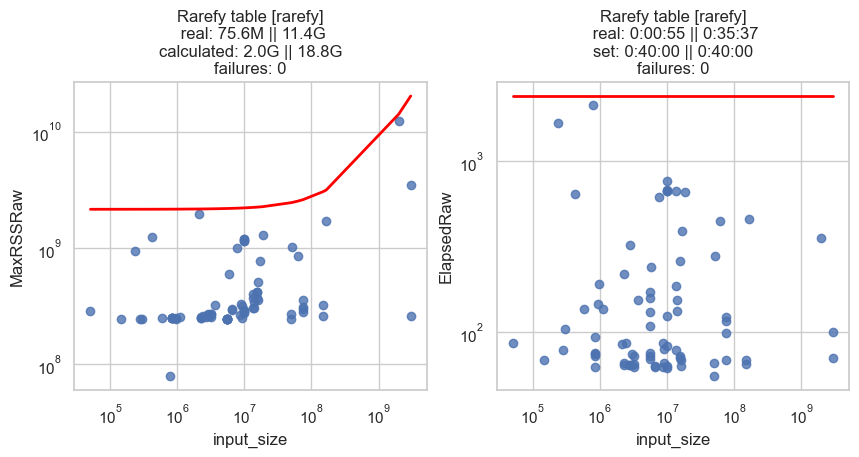

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Rarefy table [rarefy]'
_df = df[(df.cName == cname)
          & (df.updated == 'after')
         ].copy()

col_name = 'input_size'
_df.dropna(subset=[col_name], inplace=True)

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (2**31)+(x_plot*6)
_df['cMaxRSSRaw'] = (2**31)+(_df[col_name]*6)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')
# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = [2400]*len(x_plot)
_df['cElapsedRaw'] = [2400]*len(_df[col_name])

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'set: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (2**31)+({input_size}*6)'
#            || '--time 2400'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Rarefy table [rarefy]';

### Alpha diversity (phylogenetic) [alpha_phylogenetic]

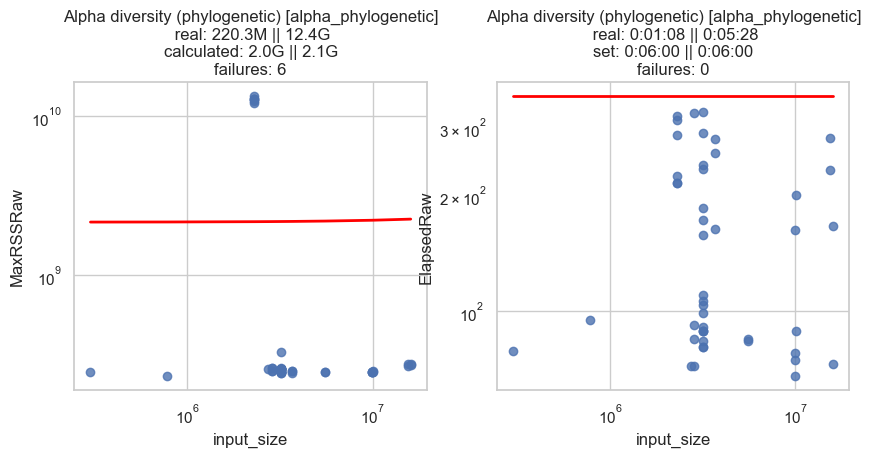

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Alpha diversity (phylogenetic) [alpha_phylogenetic]'
_df = df[(df.cName == cname)
          & (df.updated == 'after')
         ].copy()

col_name = 'input_size'
_df.dropna(subset=[col_name], inplace=True)

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (2**31)+(x_plot*6)
_df['cMaxRSSRaw'] = (2**31)+(_df[col_name]*6)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')
# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = [360]*len(x_plot)
_df['cElapsedRaw'] = [360]*len(_df[col_name])

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'set: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# This one needs to account for input size of the tree! 

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem 14g'
#            || '--time 360'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Alpha diversity (phylogenetic) [alpha_phylogenetic]';

### Pre-fitted sklearn-based taxonomy classifier [classify_sklearn]

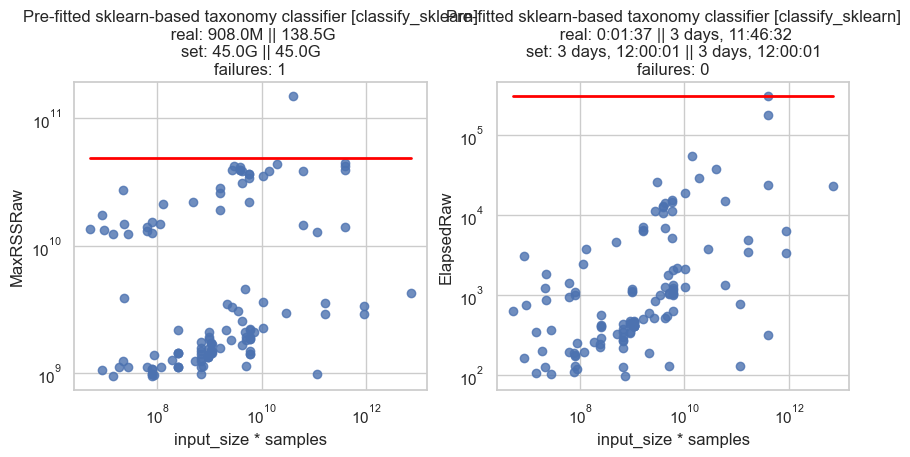

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Pre-fitted sklearn-based taxonomy classifier [classify_sklearn]'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()

col_name = 'input_size * samples'
_df[col_name] = _df['input_size'] * _df['samples']
_df.dropna(subset=[col_name], inplace=True)

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 48318382080+(x_plot/x_plot)
_df['cMaxRSSRaw'] = (48318382080)+(_df[col_name]/_df[col_name])

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'set: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')
# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 302400.0+x_plot/x_plot
_df['cElapsedRaw'] = 302400+_df[col_name]/_df[col_name]

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'set: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# This one needs to account for input size of the database! 

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem 45g'
#            || '--time 3-12:00:00'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Pre-fitted sklearn-based taxonomy classifier [classify_sklearn]';

### Visualize and Interact with Principal Coordinates Analysis Plots [plot]

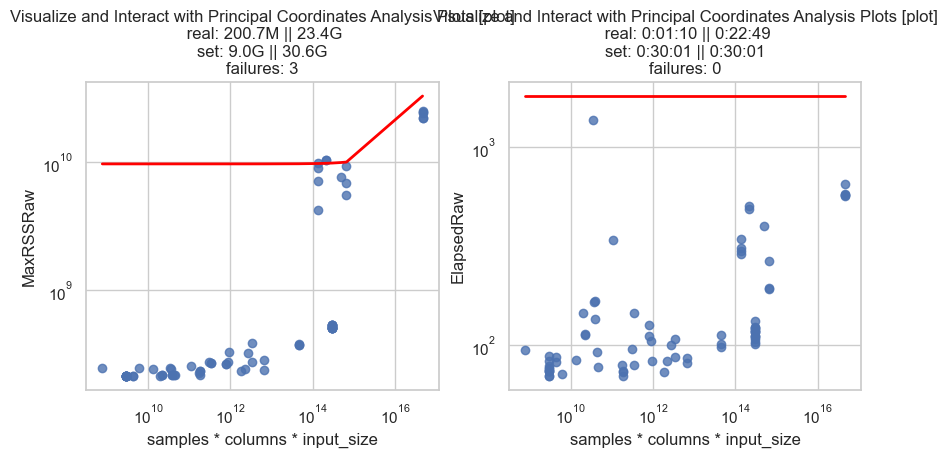

In [25]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Visualize and Interact with Principal Coordinates Analysis Plots [plot]'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()

col_name = 'samples * columns * input_size'
_df[col_name] = _df['samples'] * _df['columns'] * _df['input_size']
_df.dropna(subset=[col_name], inplace=True)

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (2**33)+ (2**30) +(x_plot/2000000)
_df['cMaxRSSRaw'] = (2**33)+ (2**30)+(_df[col_name]/2000000)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'set: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')
# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 1800+x_plot/x_plot
_df['cElapsedRaw'] = 1800+_df[col_name]/_df[col_name]

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'set: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# This one needs to account for input size of the database! 

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (2**33)+(2**30)+(({samples}*{columns}*{input_size}')/2000000)'
#            || '--time 1800'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Visualize and Interact with Principal Coordinates Analysis Plots [plot]';

### Alpha rarefaction curves [alpha_rarefaction]

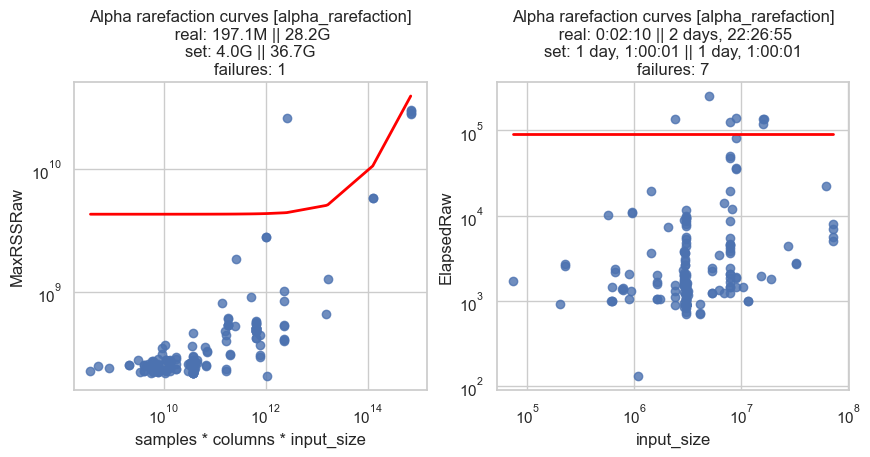

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Alpha rarefaction curves [alpha_rarefaction]'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()

col_name = 'samples * columns * input_size'
_df[col_name] = _df['samples'] * _df['columns'] * _df['input_size']
_df.dropna(subset=[col_name], inplace=True)

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (2**32)+(x_plot/20000)
_df['cMaxRSSRaw'] = (2**32)+(_df[col_name]/20000)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'set: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')

col_name = 'input_size'
# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 90000+x_plot/x_plot
_df['cElapsedRaw'] = 90000+_df[col_name]/_df[col_name]

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures_df = _df[_df.ElapsedRaw > _df.cElapsedRaw]
failures = failures_df.shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'set: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# This one needs to account for input size of the database! 

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (2**32)+(({samples}*{columns}*{input_size}')/20000)'
#            || '--time 90000'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Alpha rarefaction curves [alpha_rarefaction]';

In [27]:
df.shape

(81445, 25)